# Feedforward Neural Networks and Automatic Differentiation in PyTorch

### References

+ Automatic differentiation (in ML):
Baydin, A. G., Pearlmutter, B. A., Radul, A. A., & Siskind, J. M. (2017). Automatic differentiation in machine learning: a survey. The Journal of Machine Learning Research

+ The M.Sc. thesis by Sebastian Mitusch (Simula) gives a nice intro to forward/backward automatic differentiation (and implementation for FEniCS in dolfin-adjoint):
https://www.duo.uio.no/handle/10852/63505

## We want to train a neural network using supervised learning


## Hence we need:

0. Input-output-pairs $(x_i,y_i)$

1. Neural network $u^{NN}(\theta) \quad \qquad \qquad \rightarrow \qquad$ PyTorch: Tensors, Activation Functions, Parameters,  ... 

2. Loss function $L(\theta) = \sum (u(x_i)-y_i)^2$

3. Algorithm to find $\theta = \text{argmin} L(\theta) \qquad \rightarrow \qquad $ Gradient-based optimization: SGD, L-BFGS

4. Gradients: Automatic differentiation

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

We want to seed the random number generators, so that we get the same random numbers every time:

In [2]:
import random
random.seed(123)
print("Setting random seed")
np.random.seed(123)
torch.manual_seed(123);

Setting random seed


Check if PyTorch finds a GPU (has to be NVIDIA):

Note that for small data sets and small networks, CPU will be faster.

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU ", torch.cuda.get_device_name())
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CPU


# 0. Tensors

Basic data structure, almost like numpy.arrays, but with support fo GPU and automatic differentiation

In [4]:
x = torch.linspace(0, 1, 100, device=device)

# Can also create tensors from numpy arrays:
# x = torch.from_numpy(np.linspace(0,1,100))
# x = x.to(device)

Can often do things in numpy style:

In [5]:
x.shape

torch.Size([100])

In [6]:
torch.mean(x)

tensor(0.5000)

In [7]:
x = x[x < 0.5]

In [8]:
x.shape

torch.Size([50])

In [9]:
torch.mean(x)

tensor(0.2475)

In [10]:
x.device

device(type='cpu')

In [11]:
x.requires_grad

False

## We can transfer between python, numpy and torch:

In [12]:
x = torch.tensor([1,2])
x = x.numpy()
x

array([1, 2])

We can get Python objects:

In [13]:
x.tolist()

[1, 2]

In [14]:
x = np.array([1,2])
x = torch.from_numpy(x)
x

tensor([1, 2])

We can get Python objects:

In [15]:
x.tolist()

[1, 2]

In [16]:
x[0].item()

1

# 1. Neural Networks 

In [17]:
class Net(torch.nn.Module):

    def __init__(self, num_hidden_units, num_hidden_layers, inputs, outputs=1):
        
        super(Net, self).__init__()        
        
        self.num_hidden_units = num_hidden_units
        self.num_hidden_layers = num_hidden_layers
        
        # Dimensions of input/output
        self.inputs =  inputs
        self.outputs = outputs
        
        self.input_layer = torch.nn.Linear(self.inputs, self.num_hidden_units)
        
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(
            self.num_hidden_units, self.num_hidden_units)
            for i in range(self.num_hidden_layers - 1)])

        self.output_layer = torch.nn.Linear(self.num_hidden_units, self.outputs)
        
        # Use hyperbolic tangent as activation:
        self.activation = torch.nn.Tanh()
        
    def forward(self, x):
        """[Compute NN output]

        Args:
            x ([torch.Tensor]): input tensor
        Returns:
            [torch.Tensor]: [The NN output]
        """
        # Transform the shape of the Tensor to match what is expected by torch.nn.Linear
        x = torch.unsqueeze(x, 1) 
    
        out = self.input_layer(x)
        
        # The first hidden layer:
        out = self.activation(out)

        # The other hidden layers:
        for i, linearLayer in enumerate(self.linear_layers):
            out = linearLayer(out)
            out = self.activation(out)

        # No activation in the output layer:
        out = self.output_layer(out)

        out = torch.squeeze(out, 1)

        return out

Create a feedforward NN:

In [18]:
u_nn = Net(num_hidden_units=16, num_hidden_layers=1, inputs=1).to(device)

Let's have a look at the trainable parameters (weights and biases):

In [19]:
# Take a look at the weights in one layer:
u_nn.input_layer.weight

Parameter containing:
tensor([[-0.4078],
        [ 0.0331],
        [-0.4967],
        [ 0.3771],
        [-0.8521],
        [ 0.7330],
        [-0.7268],
        [-0.7950],
        [-0.6319],
        [ 0.4529],
        [-0.3695],
        [ 0.3742],
        [-0.8487],
        [-0.6067],
        [-0.3672],
        [-0.1965]], requires_grad=True)

In [20]:
# Print the number of tunable parameter per Parameter object
params = list(u_nn.parameters())
print(list(map(lambda x: x.numel(), params)))

[16, 16, 16, 1]


Let's have a look at the output of the untrained NN:

In [21]:
x = torch.linspace(0, 1, 100, device=device)

In [22]:
u_nn_x = u_nn(x)

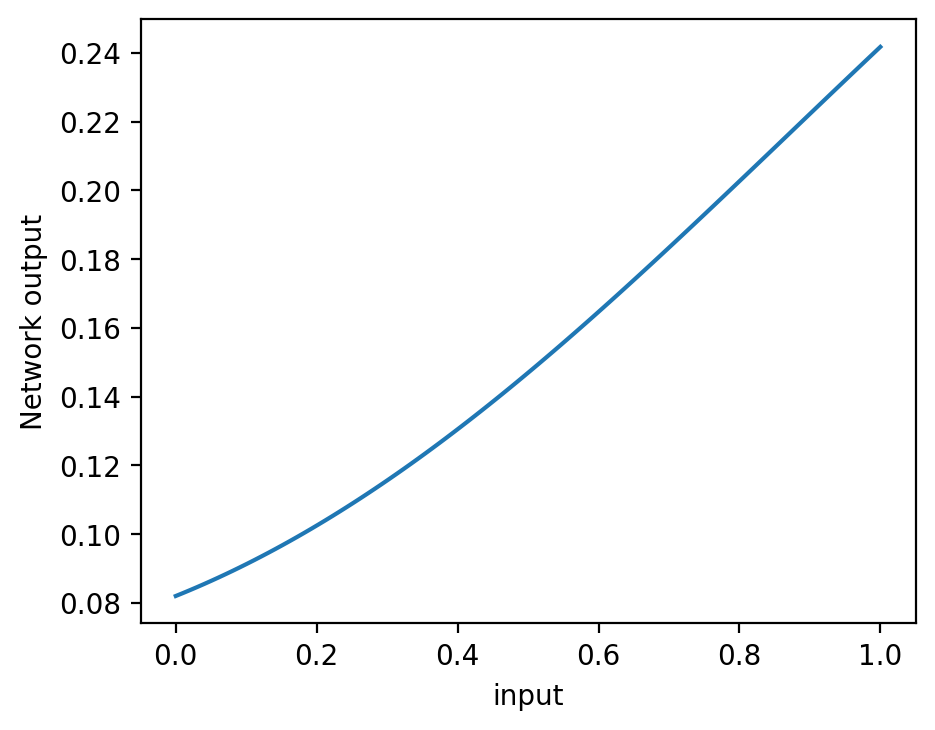

In [23]:
fig = plt.figure(figsize=(5,4),dpi=200)
plt.plot(x.numpy(), u_nn_x.detach().numpy())
plt.xlabel("input")
plt.ylabel("Network output");

# 2. Automatic (Algorithmic) differentiation

Example: Derivative of

$ f(x) = \exp(-3x^2) = v_4(v_3(v_2(v_1(x))))$

| | Forward pass: Given $x$, compute       |      
| ----| :----------------------------------------- | 
| $\downarrow$ | $v_1 = x^2$   | 
| $\downarrow$| $v_2 = 3 v_1$ | 
| $\downarrow$| $v_3 = - v_2$ 
| $\downarrow$| $v_4 = \exp v_3$ | 
|  $\downarrow$| $f = v_4 $ |$ \overline{v_4} = \frac{df }{d v_4} = 1$|


We can use the chain rule:

$\frac{df}{dx} =\frac{d f}{d v_4} \frac{d v_4}{d v_3}\frac{d v_3}{d v_2}\frac{d v_2}{d v_1}\frac{d v_1}{dx}$

and the fact that all the derivatives $\frac{d v_{i+1}}{d v_i}$ of the **elementary operations $v_{i+1}(v_i)$** can be considered known!


#### We want to have $\frac{df}{dx}$;

Let us define the adjoint variable $ \overline{v_i} = \frac{df}{dv_i}$ and start from  $ \overline{v_4}$ to compute the other $ \overline{v_i}$, utilizing 
+ the stored values $v_i$
+ Known (part of the code base) derivatives $\frac{d v_{i+1}}{d v_i}$ of the elementary operations $v_{i+1}(v_i)$

<div class="foo">
    
|  <div style="width:200px">Forward pass</div>        |           <div style="width:350px">Backward pass</div>               | |
| :----------------------------------------- | :----------------------------------------------------------| -----|
| $v_1 = x^2$   | $ \overline{x} = \frac{d f}{d x} = \overline{v_1}  \frac{d v_1}{d x}= -3 \exp (-3 x^2) \cdot 2 x $ |$\uparrow $ |
| $v_2 = 3 v_1$ | $ \overline{v_1} = \overline{v_2}  \frac{d v_2}{d v_1}= -\exp (v_3) \cdot 3$ |  $\uparrow $ |
| $v_3 = - v_2$ |$ \overline{v_2} = \overline{v_3}  \frac{d v_3}{d v_2}= \exp (v_3) \cdot (-1)$ |$\uparrow $ |
| $v_4 = \exp v_3$ | $ \overline{v_3}= \frac{d f}{d v_3} = \frac{d f}{d v_4} \frac{d v_4}{d v_3} =  \overline{v_4}  \frac{d v_4}{d v_3}= 1 \cdot \exp \color{red} v_{ \color{red} 3}  $ |$\uparrow $ |
| $f = v_4 $ |$ \overline{f} = \overline{v_4} = \frac{df }{d v_4} = 1$| $\uparrow $ |

</div>

This can also be used to compute derivatives with respect to parameters:

$ v_2 = \theta \cdot v_1 \rightarrow  f_{\theta}(x) = \exp(-\theta x^2)$

$\rightarrow \frac{df_{\theta}}{d \theta} = \frac{d f}{d v_4} \frac{d v_4}{d v_3} \frac{d v_3}{d v_2} \frac{d v_2}{d \theta} = \overline{v_2} \frac{d v_2}{d \theta} = \overline{v_2} v_1 
= - \exp (- \theta x^2 ) \cdot  x^2 $

### Let's test this:

In [24]:
theta = torch.tensor(-42., requires_grad=True)

In [25]:
def f(x, theta):
    return torch.exp(- theta * x **2)

def df_dtheta(x, theta):
    return - torch.exp(- theta * x **2) * x ** 2

In [26]:
x = torch.tensor(-1.)

x.requires_grad=True

What is the grad ?

In [27]:
x.grad is None

True

Well, nothing has been done with $x$ so far!

In [28]:
y = f(x, theta)

### So what is the grad $\frac{\partial f}{\partial \theta}$ ? 

In [29]:
x.grad is None

True

In [30]:
theta.grad is None

True

In [31]:
y.grad

/home/basti/anaconda3/envs/pytorchdemo/lib/python3.8/site-packages/torch/_tensor.py:1104: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755898319/work/build/aten/src/ATen/core/TensorBody.h:475.)
  return self._grad


In [32]:
y.backward()

In [33]:
y.grad

In [34]:
theta.grad

tensor(-1.7393e+18)

In [35]:
x.grad

tensor(-1.4610e+20)

In [36]:
x

tensor(-1., requires_grad=True)

In [37]:
theta

tensor(-42., requires_grad=True)

Is this correct ?

$\frac{df_{\theta}}{d \theta} = - \exp (- \theta x^2 ) \cdot  x^2 $

In [38]:
df_dtheta(x, theta) == theta.grad

tensor(True)

### Using PyTorch autograd to compute derivatives of functions

In [39]:
x = torch.linspace(0, 1, 100, device=device, requires_grad=True)

Two notes: 

+ `requires_grad=True` tells PyTorch to keep track of intermediate results ("create a computational graph")

+ In-place operations `x *= x` are not supported by autograd

In [40]:
y = x ** 2 # torch.sin(np.pi * x)

In [41]:
dy_dx, = torch.autograd.grad(outputs=y,
                             inputs=x,
                             grad_outputs=torch.ones_like(y),
                             create_graph=True)

ddy_dxx, = torch.autograd.grad(outputs=dy_dx,
                             inputs=x,
                             grad_outputs=torch.ones_like(dy_dx),
                             create_graph=True) 

Remark on the last arguments:

1. `grad_outputs=torch.ones_like(y)` is required for non-scalar outputs, technical reasons related to backward automatic differentiation
2. We need to set `create_graph=True` if we want to compute higher order derivatives such that PyTorch adds its computation of `dy_dx` to the computational graph (The same applies if we want to include derivatives into the loss function, because then we need derivatives with respect to NN weights)

In [42]:
# we sometimes want to convert the torch.Tensor back to python types (or numpy arrays):
# Note that a GPU tensor needs to be moved to CPU with the .cpu() call

dy_dx_list = dy_dx.tolist()
dy_dx_np = dy_dx.cpu().detach().numpy()

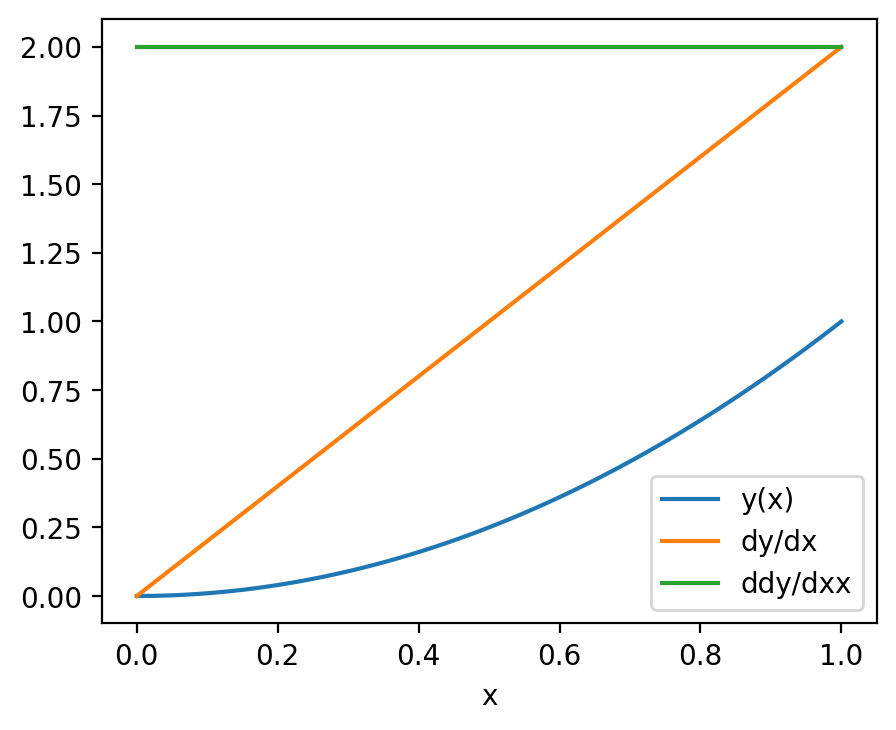

In [43]:
fig = plt.figure(figsize=(5,4),dpi=200)
plt.plot(x.tolist(), y.tolist(), label="y(x)") 
plt.plot(x.tolist(), dy_dx.tolist(), label="dy/dx") 
plt.plot(x.tolist(), ddy_dxx.tolist(), label="ddy/dxx") 
plt.xlabel("x")
plt.legend();

# 3. Training

Gradient-based optimization in a nutshell:

while criterion is True:
   1. Compute loss $L(\theta, \text{inputs})$
   2. Update the parameters as $\theta \hookleftarrow \theta - \eta \nabla_{\theta} L (\theta)$

Let's "train" a NN to to fit the sine function.

In [44]:
inputs = torch.linspace(0, 1, 100, device=device)

targets = torch.sin(np.pi * inputs)

In [45]:
u_nn = Net(num_hidden_units=16, num_hidden_layers=1, inputs=1).to(device)
params = list(u_nn.parameters())

In [46]:
optimizer = torch.optim.Adam(params=params)

In [47]:
loss_function=torch.nn.MSELoss(reduction="mean")

In [48]:
losses = []

In [49]:
max_iters = 1000

In [50]:
for i in range(max_iters):
    #  Free all intermediate values:
    optimizer.zero_grad()
    
    # Forward pass:
    predictions = u_nn(inputs)
    
    # Compute the MSE loss:
    loss = loss_function(predictions, targets)
    
    # Backward pass, compute gradient w.r.t. weights and biases
    loss.backward()
    
    # Log the loss to make a figure
    losses.append(loss.item())
    
    # Update the weights and biases
    optimizer.step()

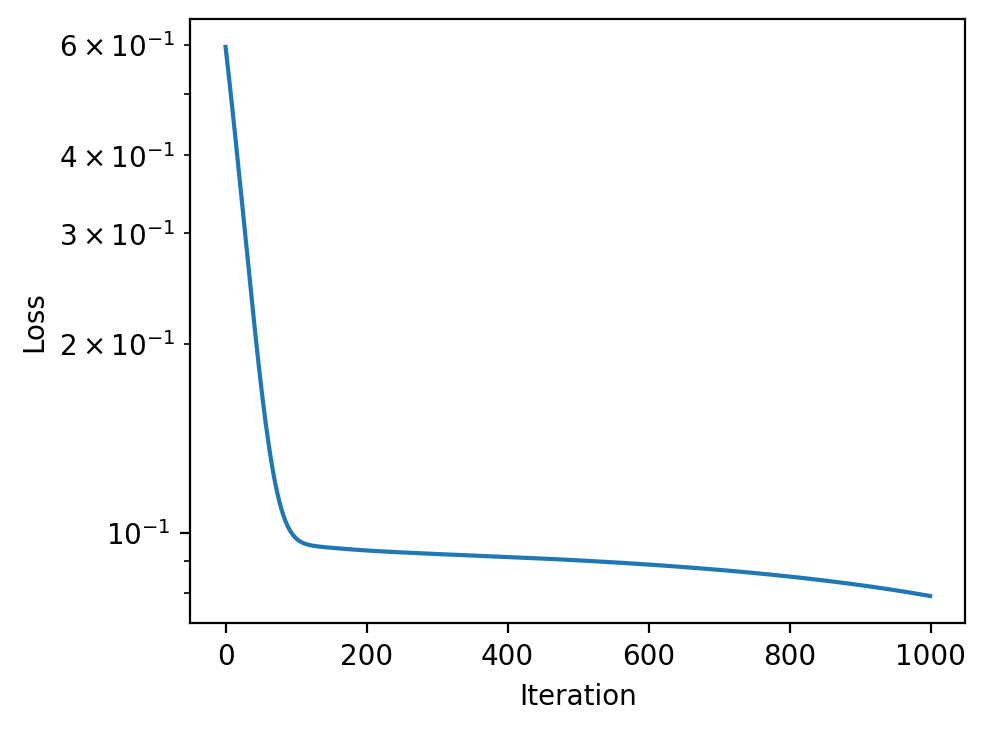

In [51]:
fig = plt.figure(figsize=(5,4),dpi=200)
plt.semilogy(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

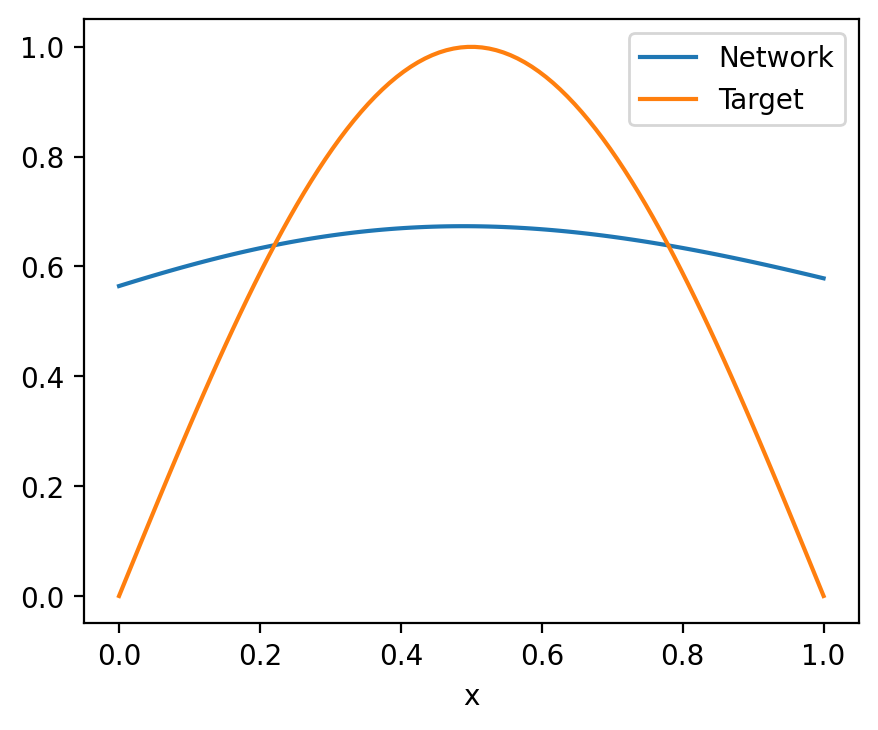

In [52]:
fig = plt.figure(figsize=(5,4),dpi=200)
plt.plot(inputs.tolist(), u_nn(inputs).tolist(), label="Network")
plt.plot(inputs.tolist(), targets.tolist(), label="Target")
plt.legend()
plt.xlabel("x")
plt.show()

# This did not work too well...
# What could have gone wrong ? 

# We can look at the gradients

In [53]:
u_nn.input_layer.weight.grad

tensor([[-0.0057],
        [-0.0007],
        [ 0.0002],
        [-0.0022],
        [ 0.0002],
        [-0.0011],
        [ 0.0042],
        [-0.0007],
        [-0.0001],
        [-0.0010],
        [-0.0010],
        [-0.0007],
        [ 0.0019],
        [ 0.0093],
        [ 0.0026],
        [ 0.0040]])

This can also be used to compute derivatives with respect to parameters:

$ v_2 = \theta \cdot v_1 \rightarrow  f_{\theta}(x) = \exp(-\theta x^2)$

$\rightarrow \frac{df_{\theta}}{d \theta} = \frac{d f}{d v_4} \frac{d v_4}{d v_3} \frac{d v_3}{d v_2} \frac{d v_2}{d \theta} = \overline{v_2} \frac{d v_2}{d \theta} = \overline{v_2} v_1 
= - \exp (- \theta x^2 ) \cdot  x^2 $

## Use a second-order method like L-BFGS:

In [54]:
u_nn = Net(num_hidden_units=16, num_hidden_layers=1, inputs=1).to(device)
params = list(u_nn.parameters())

In [55]:
lbfgs_optim = torch.optim.LBFGS(params,
                                max_iter=max_iters,
                                line_search_fn="strong_wolfe")

losses = []

L-BFGS needs to be used slightly different than first order methods in PyTorch:

The iteration happens inside `lbfgs_optim.step()`, so it is sufficient to call `lbfgs_optim.step()` only once, and specify the number of iterations with the argument `max_iter`. 

In [56]:
# L-BFGS requires one to define a method (called "closure" in the docs) 
# that evaluates the model and returns the loss:

def closure(loss_function=torch.nn.MSELoss(reduction="mean")):
    
    lbfgs_optim.zero_grad()
    
    predictions = u_nn(inputs)
    
    loss = loss_function(predictions, targets)
    
    if loss.requires_grad:
        loss.backward()
        
    losses.append(loss.item())
        
    return loss

Call L-BFGS and plot the loss:

In [57]:
lbfgs_optim.step(closure)

tensor(0.7715, grad_fn=<MseLossBackward0>)

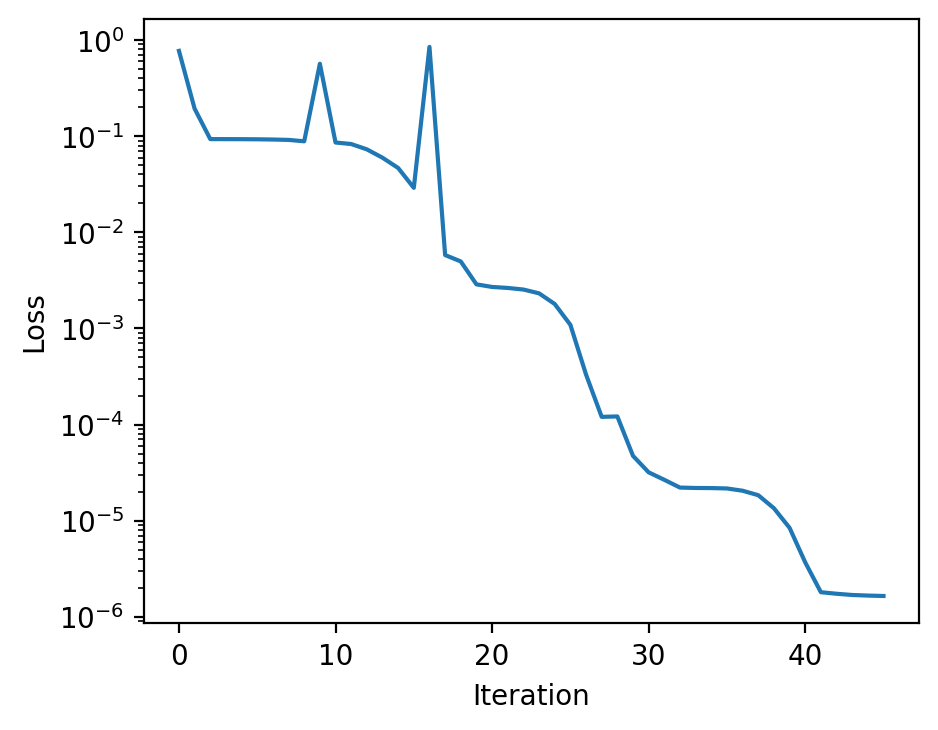

In [58]:
fig = plt.figure(figsize=(5,4),dpi=200)
plt.semilogy(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

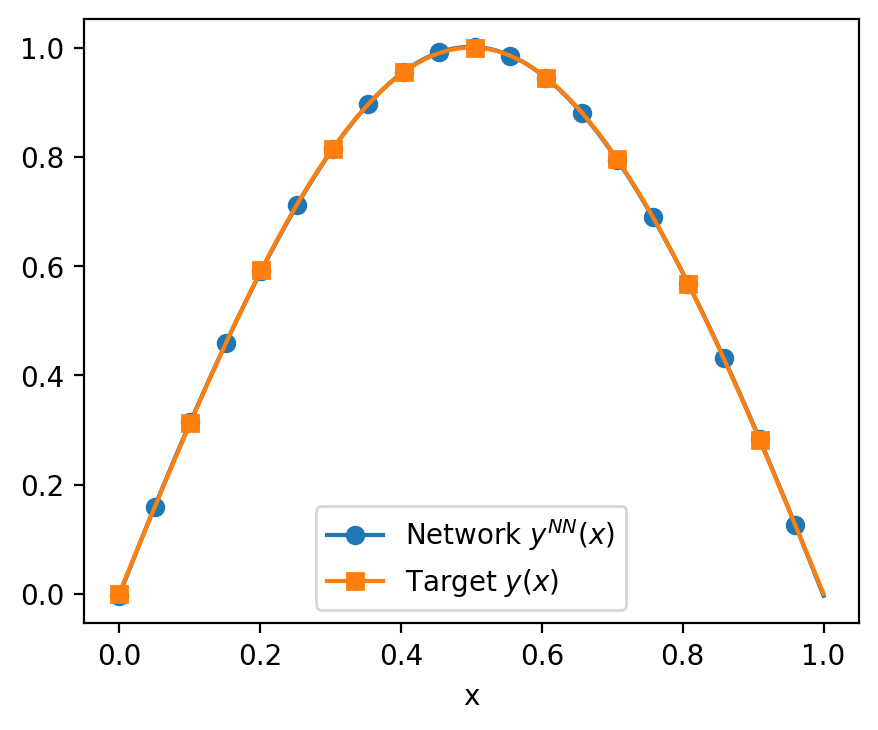

In [59]:
fig = plt.figure(figsize=(5,4),dpi=200)
plt.plot(inputs.tolist(), u_nn(inputs).tolist(), marker="o", markevery=5, label="Network $y^{NN}(x)$")
plt.plot(inputs.tolist(), targets.tolist(), marker="s", markevery=10, label="Target $y(x)$")
plt.xlabel("x")
plt.legend();

## How well does the network perform outside the training domain $[0,1]$ ? 

In [60]:
x_test = torch.linspace(-1, 2, 100)
y_test = torch.sin(torch.pi * x_test)

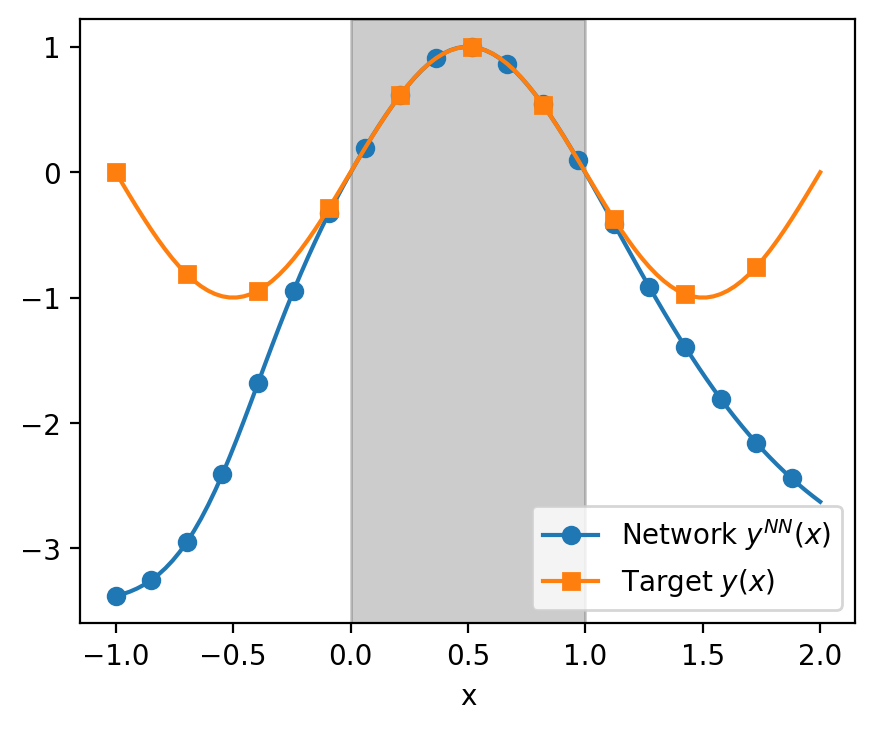

In [61]:
fig = plt.figure(figsize=(5,4),dpi=200)
ax = plt.gca()
plt.plot(x_test.tolist(), u_nn(x_test).tolist(), marker="o", markevery=5, label="Network $y^{NN}(x)$")
plt.plot(x_test.tolist(), y_test.tolist(), marker="s", markevery=10, label="Target $y(x)$")
plt.xlabel("x")
plt.axvspan(0, 1, color='k', alpha=0.2)
plt.legend();

# Let's try something more challenging

In [62]:
max_iters = 1000

In [63]:
omega = 2
inputs = torch.linspace(0, 1, 100)
targets = torch.sin(torch.pi * omega * inputs)

In [64]:
u_nn = Net(num_hidden_units=16, num_hidden_layers=1, inputs=1).to(device)
params = list(u_nn.parameters())

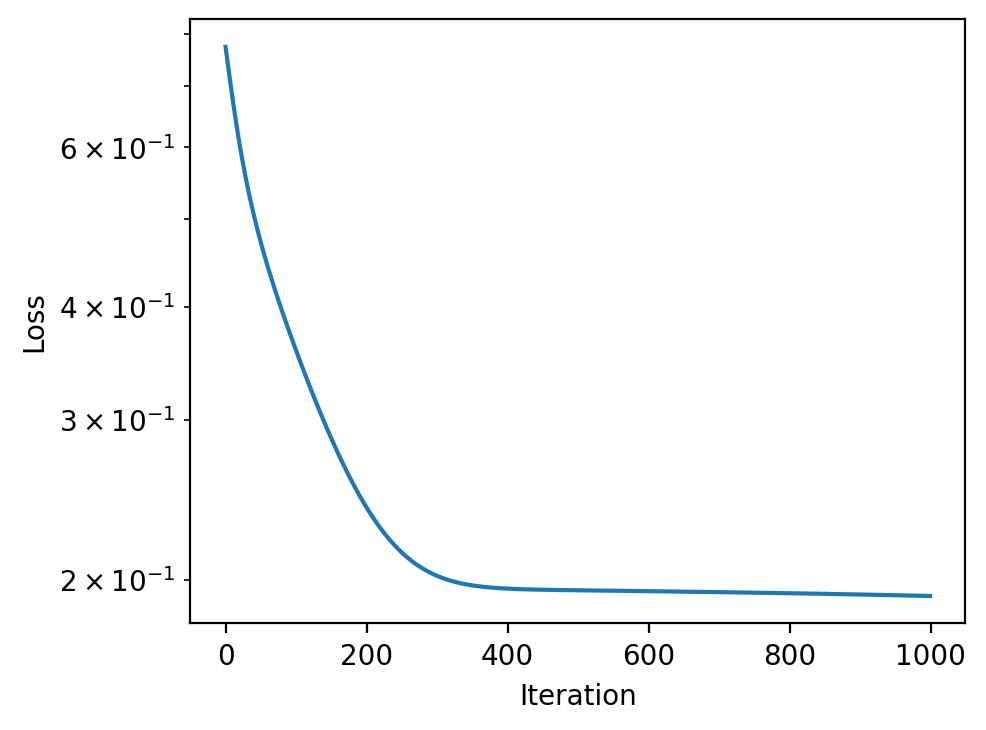

In [65]:
losses = []
optimizer = torch.optim.Adam(params=params)

for i in range(max_iters):
    #  Free all intermediate values:
    optimizer.zero_grad()
    
    # Forward pass:
    predictions = u_nn(inputs)
    
    # Compute the MSE loss:
    loss = loss_function(predictions, targets)
    
    # Backward pass, compute gradient w.r.t. weights and biases
    loss.backward()
    
    # Log the loss to make a figure
    losses.append(loss.item())
    
    # Update the weights and biases
    optimizer.step()
    
fig = plt.figure(figsize=(5,4),dpi=200)
plt.semilogy(losses);
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

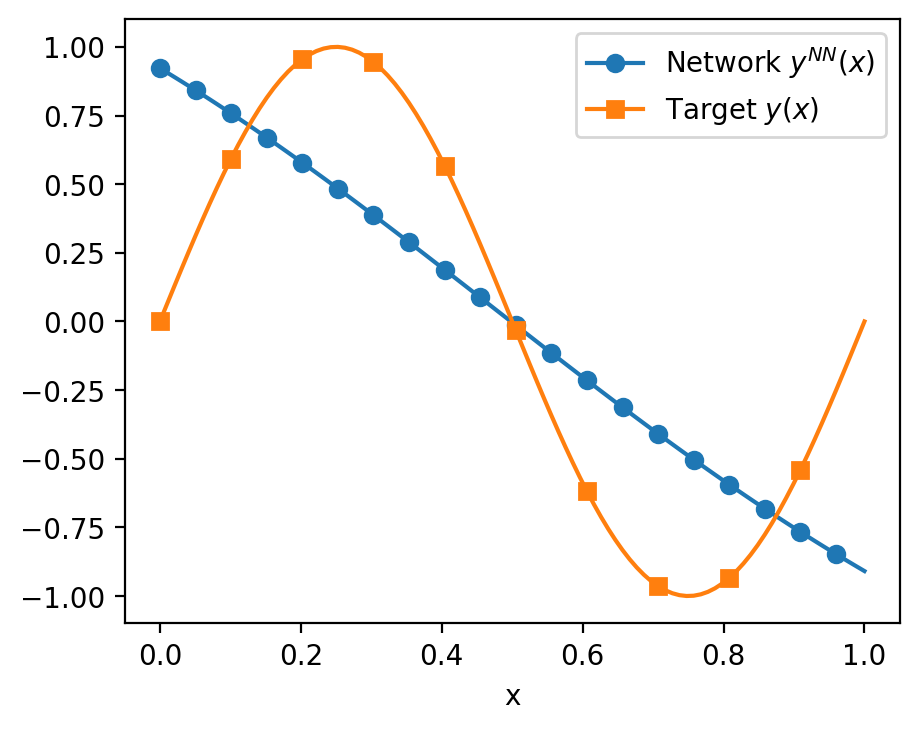

In [66]:
fig = plt.figure(figsize=(5,4),dpi=200)
plt.plot(inputs.tolist(), u_nn(inputs).tolist(), marker="o", markevery=5, label="Network $y^{NN}(x)$")
plt.plot(inputs.tolist(), targets.tolist(), marker="s", markevery=10, label="Target $y(x)$")
plt.xlabel("x")
plt.legend();

# Can we make it work with a better optimizer ?


In [67]:
u_nn = Net(num_hidden_units=16, num_hidden_layers=1, inputs=1).to(device)
params = list(u_nn.parameters())

In [68]:
# L-BFGS requires one to define a method (called "closure" in the docs) 
# that evaluates the model and returns the loss:

def closure(loss_function=torch.nn.MSELoss(reduction="mean")):
    
    lbfgs_optim.zero_grad()
    
    predictions = u_nn(inputs)
    
    loss = loss_function(predictions, targets)
    
    if loss.requires_grad:
        loss.backward()
        
    losses.append(loss.item())

    return loss

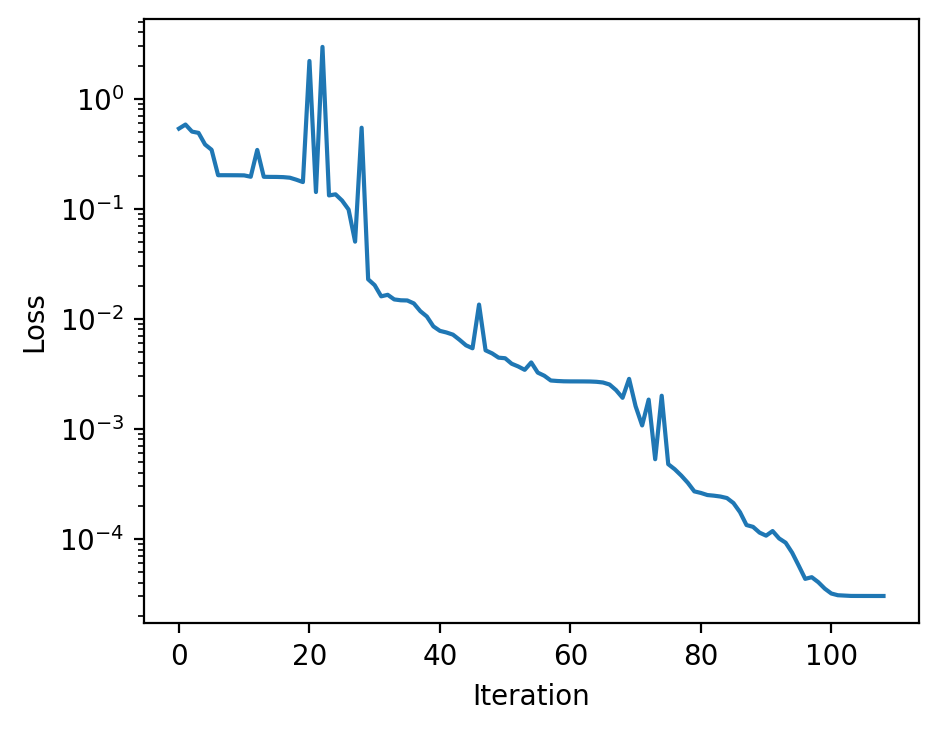

In [69]:
lbfgs_optim = torch.optim.LBFGS(params,
                                max_iter=max_iters,
                                line_search_fn="strong_wolfe")

losses = []

lbfgs_optim.step(closure)
fig = plt.figure(figsize=(5,4),dpi=200)
plt.semilogy(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

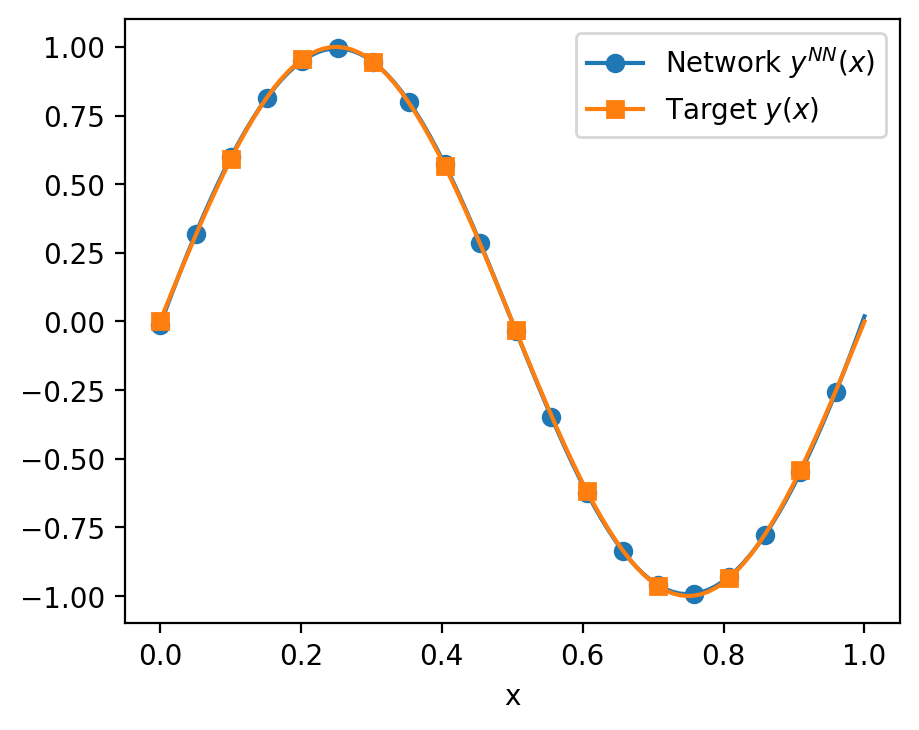

In [70]:
fig = plt.figure(figsize=(5,4),dpi=200)
plt.plot(inputs.tolist(), u_nn(inputs).tolist(), marker="o", markevery=5, label="Network $y^{NN}(x)$")
plt.plot(inputs.tolist(), targets.tolist(), marker="s", markevery=10, label="Target $y(x)$")
plt.xlabel("x")
plt.legend();